# Install Library

In [ ]:
# @title 1. Instalasi dan Impor Library
# Instalasi library yang dibutuhkan
!pip install scikit-multilearn --quiet
!pip install sastrawi --quiet
# !pip install transformers[tensorflow] --quiet
# !pip install "transformers[tensorflow]" --quiet
!pip install "transformers[tensorflow]==4.38.2" --quiet
# !pip install iterstrat-ml-stratifiers --quiet
!pip install iterative-stratification --quiet



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


# Import Library

In [2]:
# @title 1. Instalasi dan Impor Library
# Impor library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pickle
import warnings

# Sastrawi & Stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# TensorFlow, Keras, dan Transformers
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Scikit-learn & Scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import (
    accuracy_score,
    hamming_loss,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    multilabel_confusion_matrix,
    f1_score
)

# Mengatur environment
tqdm.pandas()
warnings.filterwarnings("ignore")


/Users/chairaloctavyanz/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load, Prepro, Initialization Dataset

In [3]:
# @title 2. Memuat & Preprocessing Data Teks
# Memuat dataset dari file CSV
df = pd.read_csv('dataset_berita_multilabel2.csv')
df_sw = pd.read_csv('stopwordbahasa.csv', header=None)

# --- Fungsi-fungsi preprocessing (sama seperti kode asli) ---
def text_lower(text):
    return text.lower()

def normalize_and_clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

stopword_factory = StopWordRemoverFactory()
sastrawi_stopwords = set(stopword_factory.get_stop_words())
custom_stopwords = set(df_sw[0])
all_stopwords = sastrawi_stopwords.union(custom_stopwords)

def remove_stopwords(text, stopwords_set):
    words = text.split()
    return " ".join([word for word in words if word not in stopwords_set])

# Menjalankan pipeline preprocessing
print("Memulai proses preprocessing teks...")
df['cleaned_konten'] = df['konten'].astype(str).progress_apply(text_lower)
df['cleaned_konten'] = df['cleaned_konten'].progress_apply(normalize_and_clean_text)
df['cleaned_konten'] = df['cleaned_konten'].progress_apply(lambda x: remove_stopwords(x, all_stopwords))
print("Preprocessing teks selesai.")

# --- Menyiapkan Fitur (X) dan Label (Y) ---
labels = ['hukum', 'politik', 'ekonomi']
X = df['cleaned_konten'].values
y = df[labels].values

print(f"\nBentuk data fitur (X): {X.shape}")
print(f"Bentuk data label (y): {y.shape}\n")

Memulai proses preprocessing teks...


100%|██████████| 968/968 [00:00<00:00, 505174.35it/s]

Preprocessing teks selesai.

Bentuk data fitur (X): (968,)
Bentuk data label (y): (968, 3)



# Data Spliting

In [6]:
# @title 3. Tokenisasi Menggunakan BERT Tokenizer
# Inisialisasi konstanta dan tokenizer BERT
MODEL_NAME = 'indobenchmark/indobert-base-p1'
MAX_LEN = 200 # Panjang sekuens maksimal untuk input BERT

# Muat tokenizer dari model pre-trained
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Lakukan tokenisasi pada seluruh data teks
print(f"Tokenisasi data dengan MAX_LEN={MAX_LEN}...")
X_tokenized = tokenizer(
    list(X),
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

# Konversi sparse tensor ke dense tensor jika perlu (tergantung versi TF)
X_input_ids = tf.constant(X_tokenized['input_ids'])
X_attention_mask = tf.constant(X_tokenized['attention_mask'])

print("Tokenisasi selesai.")

Tokenisasi data dengan MAX_LEN=200...
Tokenisasi selesai.


# Tokenization & Padding

In [7]:
# @title 4. Pelatihan Model BERT dengan 10-Fold Cross-Validation
# --- Inisialisasi K-Fold ---
# Gunakan MultilabelStratifiedKFold untuk menjaga distribusi kombinasi label
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# List untuk menyimpan skor dan riwayat dari setiap fold
fold_histories = []
fold_scores = []
fold_no = 1
BATCH_SIZE = 4

# --- Loop K-Fold ---
for train_index, val_index in mskf.split(X, y):
    print("-" * 50)
    print(f"--- Melatih Fold ke-{fold_no} ---")

    # --- Membagi data untuk fold saat ini ---
    # Fitur (input_ids dan attention_mask)
    X_train_ids, X_val_ids = X_input_ids.numpy()[train_index], X_input_ids.numpy()[val_index]
    X_train_mask, X_val_mask = X_attention_mask.numpy()[train_index], X_attention_mask.numpy()[val_index]
    # Label
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Gabungkan input_ids dan attention_mask ke dalam dictionary untuk model
    X_train_fold = {'input_ids': X_train_ids, 'attention_mask': X_train_mask}
    X_val_fold = {'input_ids': X_val_ids, 'attention_mask': X_val_mask}

    # --- Konversi ke tf.data.Dataset untuk efisiensi ---
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).shuffle(len(X_train_ids)).batch(BATCH_SIZE)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold)).batch(BATCH_SIZE)

    # --- Membangun Ulang Model di Setiap Fold ---
    # Model harus diinisialisasi ulang dari pre-trained state setiap iterasi
    bert_model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(labels))

    # Kompilasi model
    # optimizer = Adam(learning_rate=3e-5)
    # Sesudah diubah
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-5)
    # Gunakan from_logits=True karena output BERT adalah logits (belum diaktivasi sigmoid)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # Definisikan callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

    # --- Melatih Model ---
    print(f"\nMelatih model BERT untuk fold {fold_no}...")
    history = bert_model.fit(
        train_dataset,
        epochs=15, # Epochs bisa lebih sedikit untuk fine-tuning BERT
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    fold_histories.append(history)

    # --- Evaluasi & Menyimpan Hasil ---
    # Evaluasi pada data validasi fold ini
    scores = bert_model.evaluate(val_dataset, verbose=0)
    print(f"\nSkor untuk fold {fold_no}: Loss = {scores[0]:.4f}; Accuracy = {scores[1]:.4f}")
    fold_scores.append(scores)

    # Simpan test set dari fold terakhir untuk evaluasi final
    if fold_no == mskf.get_n_splits():
        X_test_final = X_val_fold
        y_test_final = y_val_fold
        final_model = bert_model # Simpan model dari fold terakhir

    fold_no += 1


# --- Analisis Hasil Rata-Rata Cross-Validation ---
print("\n" + "=" * 50)
print("--- Hasil Rata-Rata Cross-Validation (10-Fold) ---")
scores_array = np.array(fold_scores)

mean_loss = np.mean(scores_array[:, 0])
std_loss = np.std(scores_array[:, 0])
mean_accuracy = np.mean(scores_array[:, 1])
std_accuracy = np.std(scores_array[:, 1])

print(f"Rata-rata Loss: {mean_loss:.4f} (+/- {std_loss:.4f})")
print(f"Rata-rata Akurasi: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})")
print("=" * 50 + "\n")

--------------------------------------------------
--- Melatih Fold ke-1 ---


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 1...
Epoch 1/15
218/218 [==============================] - 174s 781ms/step - loss: 0.3305 - accuracy: 0.6651 - val_loss: 0.1898 - val_accuracy: 0.8125 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 169s 777ms/step - loss: 0.1186 - accuracy: 0.7328 - val_loss: 0.1049 - val_accuracy: 0.7708 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 168s 769ms/step - loss: 0.0539 - accuracy: 0.7982 - val_loss: 0.0729 - val_accuracy: 0.7708 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 167s 764ms/step - loss: 0.0428 - accuracy: 0.7420 - val_loss: 0.0887 - val_accuracy: 0.8854 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 169s 773ms/step - loss: 0.0380 - accuracy: 0.7638 - val_loss: 0.0847 - val_accuracy: 0.7500 - lr: 3.0000e-05
Epoch 6/15
218/218 [==============================] - 172s 787ms/step - loss: 0.0217 - accuracy: 0.6938 - val_loss: 0.0523 - val_accuracy: 0.7396 - l

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 2...
Epoch 1/15
218/218 [==============================] - 180s 808ms/step - loss: 0.3290 - accuracy: 0.6556 - val_loss: 0.1683 - val_accuracy: 0.7423 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 176s 809ms/step - loss: 0.1218 - accuracy: 0.7509 - val_loss: 0.1380 - val_accuracy: 0.7320 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 177s 810ms/step - loss: 0.0631 - accuracy: 0.7279 - val_loss: 0.1112 - val_accuracy: 0.8763 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 177s 810ms/step - loss: 0.0368 - accuracy: 0.7486 - val_loss: 0.1216 - val_accuracy: 0.8144 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 176s 807ms/step - loss: 0.0391 - accuracy: 0.7417 - val_loss: 0.1140 - val_accuracy: 0.8660 - lr: 3.0000e-05
Epoch 6/15
218/218 [==============================] - 176s 806ms/step - loss: 0.0184 - accuracy: 0.8014 - val_loss: 0.0813 - val_accuracy: 0.7835 - l

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 3...
Epoch 1/15
218/218 [==============================] - 181s 811ms/step - loss: 0.3182 - accuracy: 0.6774 - val_loss: 0.2391 - val_accuracy: 0.7320 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 179s 821ms/step - loss: 0.1062 - accuracy: 0.7164 - val_loss: 0.2156 - val_accuracy: 0.6186 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 178s 817ms/step - loss: 0.0703 - accuracy: 0.7302 - val_loss: 0.2202 - val_accuracy: 0.6907 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 177s 812ms/step - loss: 0.0577 - accuracy: 0.7486 - val_loss: 0.2792 - val_accuracy: 0.5876 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 181s 828ms/step - loss: 0.0233 - accuracy: 0.6636 - val_loss: 0.2426 - val_accuracy: 0.6289 - lr: 6.0000e-06

Skor untuk fold 3: Loss = 0.2156; Accuracy = 0.6186
--------------------------------------------------
--- Melatih Fold ke-4 ---


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 4...
Epoch 1/15
218/218 [==============================] - 177s 793ms/step - loss: 0.3032 - accuracy: 0.6923 - val_loss: 0.1375 - val_accuracy: 0.6804 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 169s 776ms/step - loss: 0.1137 - accuracy: 0.7348 - val_loss: 0.1339 - val_accuracy: 0.7732 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 170s 782ms/step - loss: 0.0671 - accuracy: 0.7761 - val_loss: 0.1953 - val_accuracy: 0.8041 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 171s 782ms/step - loss: 0.0442 - accuracy: 0.8140 - val_loss: 0.1016 - val_accuracy: 0.8660 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 169s 776ms/step - loss: 0.0448 - accuracy: 0.7635 - val_loss: 0.1419 - val_accuracy: 0.7629 - lr: 3.0000e-05
Epoch 6/15
218/218 [==============================] - 171s 786ms/step - loss: 0.0248 - accuracy: 0.7715 - val_loss: 0.0816 - val_accuracy: 0.7010 - l

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 5...
Epoch 1/15
218/218 [==============================] - 174s 779ms/step - loss: 0.3080 - accuracy: 0.6889 - val_loss: 0.0994 - val_accuracy: 0.7629 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 169s 777ms/step - loss: 0.1103 - accuracy: 0.7532 - val_loss: 0.1016 - val_accuracy: 0.7320 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 170s 781ms/step - loss: 0.0617 - accuracy: 0.7440 - val_loss: 0.0881 - val_accuracy: 0.7835 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 170s 782ms/step - loss: 0.0426 - accuracy: 0.7600 - val_loss: 0.0665 - val_accuracy: 0.6598 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 170s 781ms/step - loss: 0.0162 - accuracy: 0.7738 - val_loss: 0.0885 - val_accuracy: 0.7010 - lr: 3.0000e-05
Epoch 6/15
218/218 [==============================] - 170s 780ms/step - loss: 0.0127 - accuracy: 0.7773 - val_loss: 0.0737 - val_accuracy: 0.8763 - l

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 6...
Epoch 1/15
218/218 [==============================] - 175s 787ms/step - loss: 0.3478 - accuracy: 0.6697 - val_loss: 0.1654 - val_accuracy: 0.8854 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 171s 784ms/step - loss: 0.1248 - accuracy: 0.7374 - val_loss: 0.1107 - val_accuracy: 0.8958 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 172s 791ms/step - loss: 0.0642 - accuracy: 0.6938 - val_loss: 0.0950 - val_accuracy: 0.7708 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 170s 778ms/step - loss: 0.0408 - accuracy: 0.7282 - val_loss: 0.1081 - val_accuracy: 0.7500 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 171s 782ms/step - loss: 0.0295 - accuracy: 0.7282 - val_loss: 0.1084 - val_accuracy: 0.7083 - lr: 3.0000e-05
Epoch 6/15
218/218 [==============================] - 169s 776ms/step - loss: 0.0154 - accuracy: 0.6732 - val_loss: 0.0843 - val_accuracy: 0.6979 - l

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 7...
Epoch 1/15
218/218 [==============================] - 176s 786ms/step - loss: 0.3002 - accuracy: 0.7141 - val_loss: 0.1620 - val_accuracy: 0.6392 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 170s 780ms/step - loss: 0.1172 - accuracy: 0.7532 - val_loss: 0.0742 - val_accuracy: 0.6082 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 171s 784ms/step - loss: 0.0646 - accuracy: 0.7750 - val_loss: 0.0664 - val_accuracy: 0.8763 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 170s 781ms/step - loss: 0.0461 - accuracy: 0.7555 - val_loss: 0.0455 - val_accuracy: 0.6082 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 170s 780ms/step - loss: 0.0317 - accuracy: 0.7394 - val_loss: 0.0603 - val_accuracy: 0.6804 - lr: 3.0000e-05
Epoch 6/15
218/218 [==============================] - 169s 776ms/step - loss: 0.0292 - accuracy: 0.7842 - val_loss: 0.1004 - val_accuracy: 0.5773 - l

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 8...
Epoch 1/15
218/218 [==============================] - 175s 786ms/step - loss: 0.3049 - accuracy: 0.6969 - val_loss: 0.1188 - val_accuracy: 0.7113 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 172s 789ms/step - loss: 0.1143 - accuracy: 0.7394 - val_loss: 0.0962 - val_accuracy: 0.7732 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 172s 788ms/step - loss: 0.0614 - accuracy: 0.7497 - val_loss: 0.0898 - val_accuracy: 0.8763 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 171s 786ms/step - loss: 0.0340 - accuracy: 0.7313 - val_loss: 0.0932 - val_accuracy: 0.8454 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 171s 786ms/step - loss: 0.0128 - accuracy: 0.7164 - val_loss: 0.0577 - val_accuracy: 0.7216 - lr: 3.0000e-05
Epoch 6/15
218/218 [==============================] - 172s 790ms/step - loss: 0.0157 - accuracy: 0.7233 - val_loss: 0.0837 - val_accuracy: 0.6082 - l

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 9...
Epoch 1/15
218/218 [==============================] - 177s 793ms/step - loss: 0.2959 - accuracy: 0.7026 - val_loss: 0.2139 - val_accuracy: 0.6186 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 171s 786ms/step - loss: 0.1148 - accuracy: 0.7761 - val_loss: 0.1378 - val_accuracy: 0.7320 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 172s 790ms/step - loss: 0.0557 - accuracy: 0.7245 - val_loss: 0.1261 - val_accuracy: 0.7629 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 172s 788ms/step - loss: 0.0363 - accuracy: 0.7612 - val_loss: 0.1888 - val_accuracy: 0.7629 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 171s 786ms/step - loss: 0.0231 - accuracy: 0.7130 - val_loss: 0.1267 - val_accuracy: 0.6186 - lr: 3.0000e-05
Epoch 6/15
218/218 [==============================] - 171s 786ms/step - loss: 0.0105 - accuracy: 0.7245 - val_loss: 0.0999 - val_accuracy: 0.7423 - l

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Melatih model BERT untuk fold 10...
Epoch 1/15
218/218 [==============================] - 177s 792ms/step - loss: 0.3068 - accuracy: 0.6670 - val_loss: 0.1252 - val_accuracy: 0.7629 - lr: 3.0000e-05
Epoch 2/15
218/218 [==============================] - 172s 788ms/step - loss: 0.1206 - accuracy: 0.7325 - val_loss: 0.1365 - val_accuracy: 0.8763 - lr: 3.0000e-05
Epoch 3/15
218/218 [==============================] - 172s 790ms/step - loss: 0.0599 - accuracy: 0.7738 - val_loss: 0.0813 - val_accuracy: 0.7423 - lr: 3.0000e-05
Epoch 4/15
218/218 [==============================] - 172s 789ms/step - loss: 0.0307 - accuracy: 0.7290 - val_loss: 0.0795 - val_accuracy: 0.7629 - lr: 3.0000e-05
Epoch 5/15
218/218 [==============================] - 172s 788ms/step - loss: 0.0264 - accuracy: 0.7382 - val_loss: 0.0772 - val_accuracy: 0.7835 - lr: 3.0000e-05
Epoch 6/15
218/218 [==============================] - 171s 786ms/step - loss: 0.0216 - accuracy: 0.7382 - val_loss: 0.0801 - val_accuracy: 0.7938 - 

4/4 [==============================] - 5s 1s/step
--- Laporan Evaluasi Model Multilabel ---
🎯 Subset Accuracy (Kecocokan Penuh): 0.9278
🔻 Hamming Loss (Rata-rata Kesalahan per Label): 0.0241

--- Skor ROC-AUC (Per Label & Rata-rata) ---
📈 ROC-AUC (Macro Average): 0.9933
📈 ROC-AUC (Weighted Average): 0.9951

Skor ROC-AUC per Label:
   - Hukum     : 0.9800
   - Politik   : 1.0000
   - Ekonomi   : 1.0000

--- Laporan Klasifikasi (Per Label Individu) ---
              precision    recall  f1-score   support

       hukum       0.96      0.88      0.92        25
     politik       0.97      1.00      0.98        57
     ekonomi       0.95      1.00      0.98        21

   micro avg       0.96      0.97      0.97       103
   macro avg       0.96      0.96      0.96       103
weighted avg       0.96      0.97      0.97       103
 samples avg       0.84      0.85      0.84       103


--- Confusion Matrix (Per Label Individu) ---


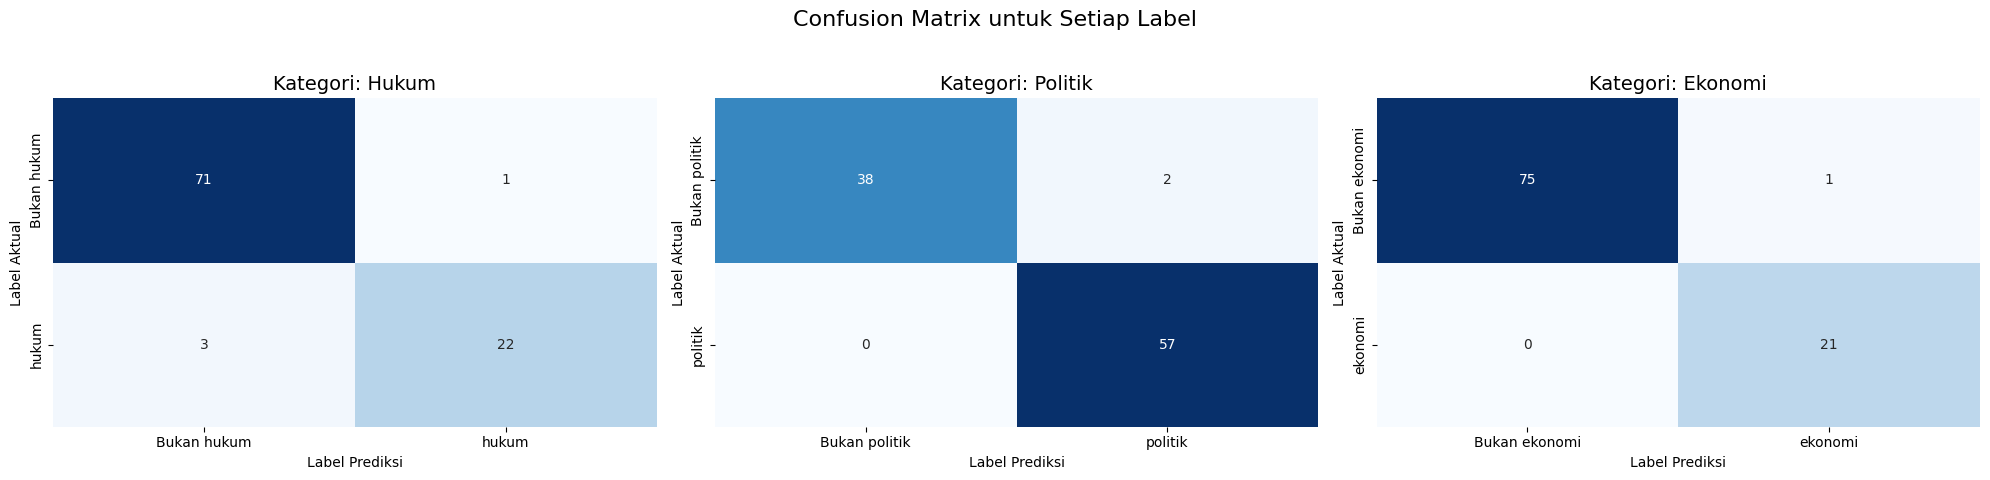



--- Laporan Evaluasi Berdasarkan Kombinasi Label (Format Tabel) ---


,precision,recall,f1-score,support
ekonomi,1.00,0.91,0.95,11.00
hukum,1.00,0.86,0.92,14.00
hukum-ekonomi,0.67,1.00,0.80,2.00
hukum-politik,0.86,0.86,0.86,7.00
hukum-politik-ekonomi,1.00,0.50,0.67,2.00
lainnya,0.92,0.92,0.92,13.00
politik,0.95,0.98,0.96,42.00
politik-ekonomi,0.75,1.00,0.86,6.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.89,0.88,0.87,97.00



📈 Confusion Matrix (Berdasarkan Kombinasi Label):


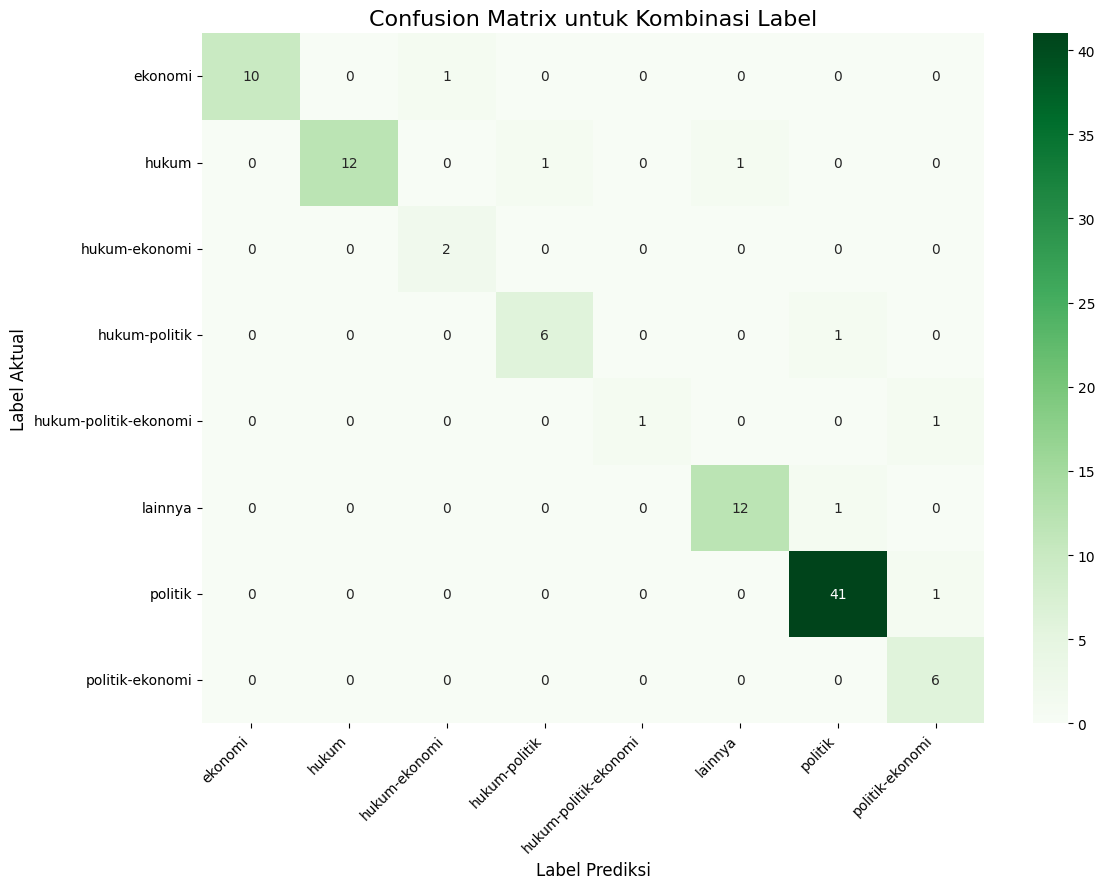

In [8]:
# @title 5. Evaluasi Final Lengkap (Per-Label, Kombinasi Label, dan ROC-AUC)

# Prediksi probabilitas (logits) dari model final
y_pred_logits = final_model.predict(X_test_final)['logits']

# Konversi logits ke probabilitas menggunakan Sigmoid
y_pred_proba = tf.nn.sigmoid(y_pred_logits).numpy()

# Konversi probabilitas ke prediksi biner dengan threshold 0.5
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# ==============================================================================
# --- BAGIAN 1: LAPORAN EVALUASI PER-LABEL INDIVIDU ---
# ==============================================================================

# --- Metrik Multilabel Standar ---
print("--- Laporan Evaluasi Model Multilabel ---")
subset_accuracy = accuracy_score(y_test_final, y_pred_binary)
print(f"🎯 Subset Accuracy (Kecocokan Penuh): {subset_accuracy:.4f}")

hamming = hamming_loss(y_test_final, y_pred_binary)
print(f"🔻 Hamming Loss (Rata-rata Kesalahan per Label): {hamming:.4f}")

# --- Skor ROC-AUC (BARU DITAMBAHKAN) ---
print("\n--- Skor ROC-AUC (Per Label & Rata-rata) ---")
try:
    roc_auc_macro = roc_auc_score(y_test_final, y_pred_proba, average='macro')
    roc_auc_weighted = roc_auc_score(y_test_final, y_pred_proba, average='weighted')
    print(f"📈 ROC-AUC (Macro Average): {roc_auc_macro:.4f}")
    print(f"📈 ROC-AUC (Weighted Average): {roc_auc_weighted:.4f}\n")
    print("Skor ROC-AUC per Label:")
    for i, label in enumerate(labels):
        roc_label = roc_auc_score(y_test_final[:, i], y_pred_proba[:, i])
        print(f"   - {label.capitalize():<10}: {roc_label:.4f}")
except ValueError:
    print("Tidak dapat menghitung ROC-AUC. Kemungkinan ada label yang tidak memiliki sampel di test set.")

# --- Laporan Klasifikasi per Label ---
print("\n--- Laporan Klasifikasi (Per Label Individu) ---")
print(classification_report(y_test_final, y_pred_binary, target_names=labels, zero_division=0))

# --- Confusion Matrix per Label ---
print("\n--- Confusion Matrix (Per Label Individu) ---")
cm_per_label = multilabel_confusion_matrix(y_test_final, y_pred_binary)

fig, axes = plt.subplots(1, len(labels), figsize=(20, 5))
fig.suptitle('Confusion Matrix untuk Setiap Label', fontsize=16)

for i, (matrix, label) in enumerate(zip(cm_per_label, labels)):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=[f'Bukan {label}', label],
                yticklabels=[f'Bukan {label}', label])
    axes[i].set_title(f'Kategori: {label.capitalize()}', fontsize=14)
    axes[i].set_ylabel('Label Aktual')
    axes[i].set_xlabel('Label Prediksi')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ==============================================================================
# --- BAGIAN 2: LAPORAN EVALUASI BERDASARKAN KOMBINASI LABEL ---
# ==============================================================================
print("\n" + "="*60)

# --- Fungsi untuk mengubah prediksi biner menjadi label kombinasi ---
def interpret_binary_to_string_label(binary_predictions):
    label_map = {
        (1, 0, 0): "hukum", (0, 1, 0): "politik", (0, 0, 1): "ekonomi",
        (1, 1, 0): "hukum-politik", (1, 0, 1): "hukum-ekonomi",
        (0, 1, 1): "politik-ekonomi", (1, 1, 1): "hukum-politik-ekonomi",
        (0, 0, 0): "lainnya"
    }
    final_labels = [label_map.get(tuple(pred), "kombinasi_lain") for pred in binary_predictions]
    return np.array(final_labels)

y_true_combination = interpret_binary_to_string_label(y_test_final)
y_pred_combination = interpret_binary_to_string_label(y_pred_binary)
all_possible_classes = sorted(list(set(y_true_combination) | set(y_pred_combination)))

# --- Laporan Klasifikasi Berdasarkan Kombinasi ---
print("\n--- Laporan Evaluasi Berdasarkan Kombinasi Label (Format Tabel) ---")
report_dict = classification_report(y_true_combination, y_pred_combination, labels=all_possible_classes, zero_division=0, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
display(report_df.round(2))

# --- Confusion Matrix Berdasarkan Kombinasi ---
print("\n📈 Confusion Matrix (Berdasarkan Kombinasi Label):")
cm_combination = confusion_matrix(y_true_combination, y_pred_combination, labels=all_possible_classes)
plt.figure(figsize=(12, 9))
sns.heatmap(cm_combination, annot=True, fmt='d', cmap='Greens',
            xticklabels=all_possible_classes, yticklabels=all_possible_classes)
plt.title('Confusion Matrix untuk Kombinasi Label', fontsize=16)
plt.ylabel('Label Aktual', fontsize=12)
plt.xlabel('Label Prediksi', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
# Konversi Model
# Simpan Model Keras yang sudah dilatih
# from pickle import pickle

final_model.save("bert_model_hpe.keras")
print("Model telah disimpan sebagai 'bilstm_model.keras'")

# Simpan Tokenizer
with open('tokenizer-bert.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer telah disimpan sebagai 'tokenizer.pickle'")
    
# Simpan daftar stopwords
with open('stopwords.pickle', 'wb') as handle:
    pickle.dump(all_stopwords, handle)
print("Daftar stopwords telah disimpan sebagai 'stopwords.pickle'")

# Simpan variabel MAX_LEN
with open('max_len.pickle', 'wb') as handle:
    pickle.dump(MAX_LEN, handle)
print(f"MAX_LEN ({MAX_LEN}) telah disimpan sebagai 'max_len.pickle'")

print("\nSemua komponen yang diperlukan telah disimpan!")


Model telah disimpan sebagai 'bilstm_model.keras'
Tokenizer telah disimpan sebagai 'tokenizer.pickle'
Daftar stopwords telah disimpan sebagai 'stopwords.pickle'
MAX_LEN (200) telah disimpan sebagai 'max_len.pickle'

Semua komponen yang diperlukan telah disimpan!


Membuat word cloud untuk setiap label...


NameError: name 'WordCloud' is not defined

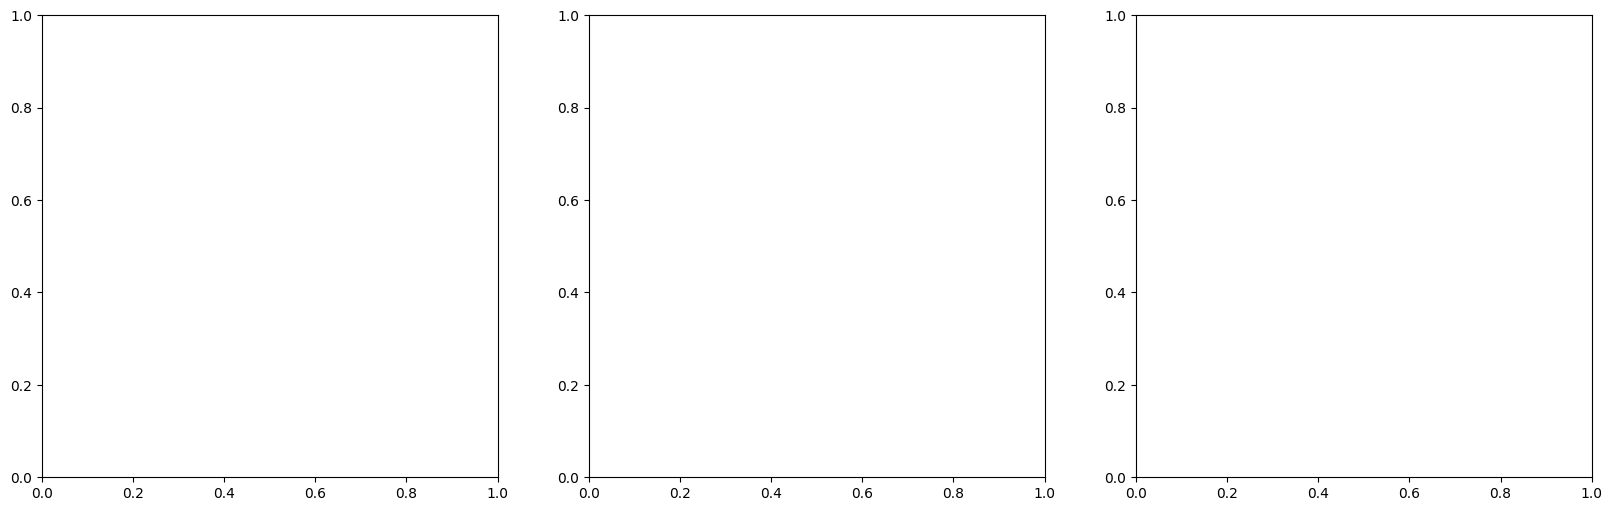

In [10]:
# @title Bonus: Visualisasi Word Cloud per Label



# Pastikan DataFrame 'df' dengan kolom 'cleaned_konten' dan kolom label sudah tersedia

# Daftar label yang ingin dibuatkan word cloud
labels_to_visualize = ['hukum', 'politik', 'ekonomi']

print("Membuat word cloud untuk setiap label...")

# Atur layout plot agar bisa menampilkan beberapa gambar sekaligus
fig, axes = plt.subplots(1, len(labels_to_visualize), figsize=(20, 6))

for i, label in enumerate(labels_to_visualize):
    # 1. Filter teks yang hanya memiliki label yang bersangkutan
    # Ambil semua baris di mana kolom label ini bernilai 1
    text_for_label = df[df[label] == 1]['cleaned_konten']
    
    # 2. Gabungkan semua baris teks menjadi satu string panjang
    long_string = ' '.join(text_for_label)
    
    # 3. Buat objek WordCloud
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='white', 
                          colormap='viridis',
                          min_font_size=10).generate(long_string)
    
    # 4. Tampilkan gambar menggunakan matplotlib
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud untuk Label: {label.capitalize()}', fontsize=15)
    ax.axis('off') # Hilangkan sumbu x dan y

plt.tight_layout()
plt.show()

In [ ]:
# !pip install iterative-stratification


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


7/7 [==============================] - 0s 17ms/step
--- Laporan Evaluasi Model Multilabel ---
🎯 Subset Accuracy (Kecocokan Penuh): 0.9330
🔻 Hamming Loss (Rata-rata Kesalahan per Label): 0.0223

--- Skor ROC-AUC (Per Label & Rata-rata) ---
📈 ROC-AUC (Macro Average): 0.9905
📈 ROC-AUC (Weighted Average): 0.9915

Skor ROC-AUC per Label:
   - Hukum     : 0.9996
   - Politik   : 0.9924
   - Ekonomi   : 0.9796

--- Laporan Klasifikasi (Per Label Individu) ---
              precision    recall  f1-score   support

       hukum       0.96      1.00      0.98        50
     politik       0.97      0.99      0.98       116
     ekonomi       0.97      0.86      0.91        42

   micro avg       0.97      0.97      0.97       208
   macro avg       0.97      0.95      0.96       208
weighted avg       0.97      0.97      0.97       208
 samples avg       0.78      0.77      0.77       208


--- Confusion Matrix (Per Label Individu) ---


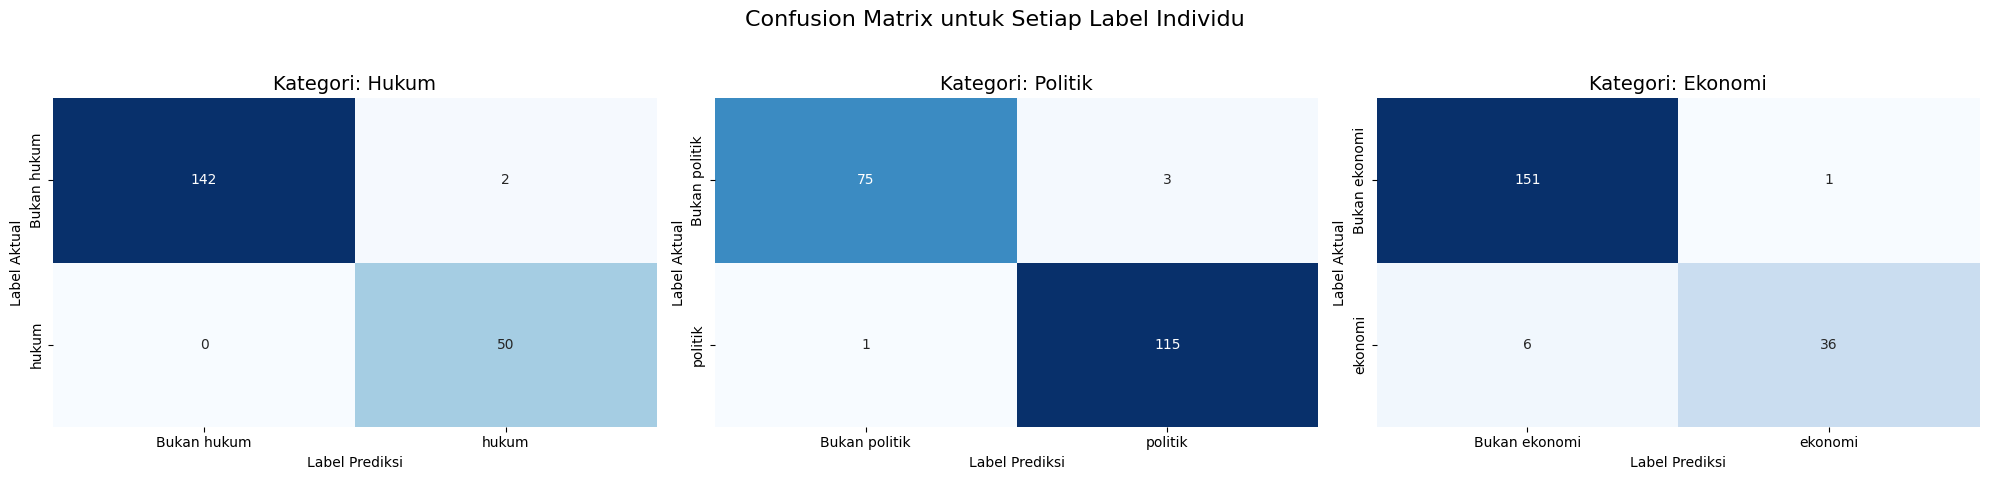



--- Laporan Evaluasi Berdasarkan 7 Kombinasi Label (Format Tabel) ---


,precision,recall,f1-score,support
ekonomi,0.92,0.92,0.92,13.00
hukum,0.91,1.00,0.95,21.00
hukum-ekonomi,1.00,0.25,0.40,4.00
hukum-politik,0.95,1.00,0.97,18.00
hukum-politik-ekonomi,0.67,0.86,0.75,7.00
lainnya,0.95,0.92,0.94,40.00
politik,0.95,0.99,0.97,73.00
politik-ekonomi,1.00,0.78,0.88,18.00
accuracy,0.93,0.93,0.93,0.93
macro avg,0.92,0.84,0.85,194.00



📈 Confusion Matrix (Berdasarkan 7 Kombinasi Label):


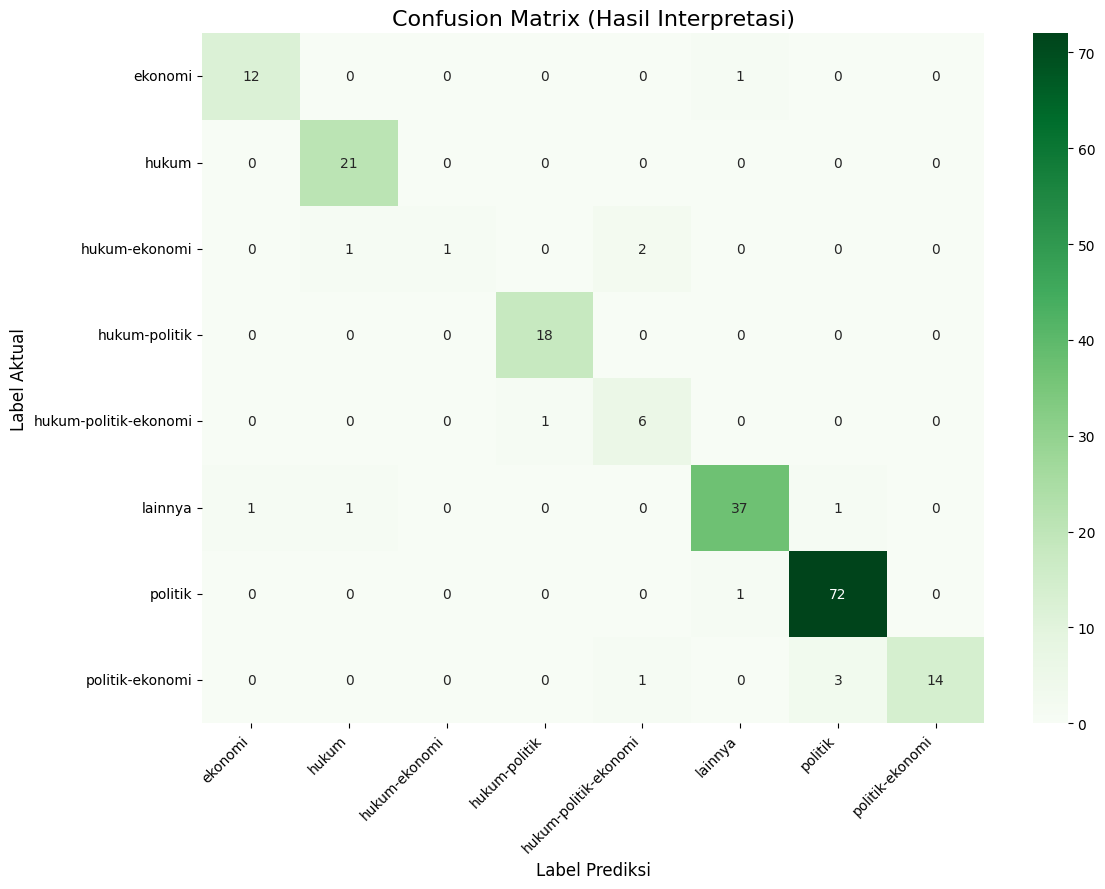

In [ ]:
# # @title 7. Evaluasi Model (Laporan Lengkap dengan Semua Confusion Matrix)



# # Langkah 1 & 2: Prediksi dan konversi ke biner
# y_pred_proba = model_kfold.predict(X_test_pad)
# y_pred_binary = (y_pred_proba > 0.5).astype(int)

# # --- Evaluasi Metrik Multilabel Standar ---
# print("--- Laporan Evaluasi Model Multilabel ---")
# subset_accuracy = accuracy_score(y_test, y_pred_binary)
# print(f"🎯 Subset Accuracy (Kecocokan Penuh): {subset_accuracy:.4f}")

# hamming = hamming_loss(y_test, y_pred_binary)
# print(f"🔻 Hamming Loss (Rata-rata Kesalahan per Label): {hamming:.4f}")

# # --- Skor ROC-AUC ---
# print("\n--- Skor ROC-AUC (Per Label & Rata-rata) ---")
# try:
#     roc_auc_macro = roc_auc_score(y_test, y_pred_proba, average='macro')
#     roc_auc_weighted = roc_auc_score(y_test, y_pred_proba, average='weighted')
#     print(f"📈 ROC-AUC (Macro Average): {roc_auc_macro:.4f}")
#     print(f"📈 ROC-AUC (Weighted Average): {roc_auc_weighted:.4f}\n")
#     print("Skor ROC-AUC per Label:")
#     for i, label in enumerate(labels):
#         roc_label = roc_auc_score(y_test[:, i], y_pred_proba[:, i])
#         print(f"   - {label.capitalize():<10}: {roc_label:.4f}")
# except ValueError:
#     print("Tidak dapat menghitung ROC-AUC.")

# # --- Laporan Klasifikasi per Label ---
# print("\n--- Laporan Klasifikasi (Per Label Individu) ---")
# print(classification_report(y_test, y_pred_binary, target_names=labels, zero_division=0))


# # --- KODE BARU UNTUK CONFUSION MATRIX PER LABEL INDIVIDU ---
# print("\n--- Confusion Matrix (Per Label Individu) ---")
# cm_per_label = multilabel_confusion_matrix(y_test, y_pred_binary)

# fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# fig.suptitle('Confusion Matrix untuk Setiap Label Individu', fontsize=16)

# for i, (matrix, label) in enumerate(zip(cm_per_label, labels)):
#     sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
#                 xticklabels=[f'Bukan {label}', label],
#                 yticklabels=[f'Bukan {label}', label])
#     axes[i].set_title(f'Kategori: {label.capitalize()}', fontsize=14)
#     axes[i].set_ylabel('Label Aktual')
#     axes[i].set_xlabel('Label Prediksi')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()
# # --- AKHIR DARI KODE BARU ---


# # --- Interpretasi menjadi 7 Kombinasi untuk Laporan Tabel ---
# def interpret_binary_to_string_label(binary_predictions):
#     label_map = {
#         (1, 0, 0): "hukum", (0, 0, 1): "ekonomi", (0, 1, 0): "politik",
#         (1, 0, 1): "hukum-ekonomi", (1, 1, 0): "hukum-politik",
#         (0, 1, 1): "politik-ekonomi", (1, 1, 1): "hukum-politik-ekonomi",
#         (0, 0, 0): "lainnya"
#     }
#     final_labels = [label_map.get(tuple(pred), "lainnya") for pred in binary_predictions]
#     return np.array(final_labels)

# # (Sisa kode untuk laporan kombinasi dan confusion matrix kombinasi tidak perlu diubah)
# y_pred_combination = interpret_binary_to_string_label(y_pred_binary)
# y_true_combination = interpret_binary_to_string_label(y_test)
# all_possible_classes = sorted(list(set(y_true_combination) | set(y_pred_combination)))

# print("\n\n--- Laporan Evaluasi Berdasarkan 7 Kombinasi Label (Format Tabel) ---")
# report_dict = classification_report(y_true_combination, y_pred_combination, labels=all_possible_classes, zero_division=0, output_dict=True)
# report_df = pd.DataFrame(report_dict).transpose()
# display(report_df.round(2))

# print("\n📈 Confusion Matrix (Berdasarkan 7 Kombinasi Label):")
# cm_combination = confusion_matrix(y_true_combination, y_pred_combination, labels=all_possible_classes)
# plt.figure(figsize=(12, 9))
# sns.heatmap(cm_combination, annot=True, fmt='d', cmap='Greens',
#             xticklabels=all_possible_classes, yticklabels=all_possible_classes)
# plt.title('Confusion Matrix (Hasil Interpretasi)', fontsize=16)
# plt.ylabel('Label Aktual', fontsize=12)
# plt.xlabel('Label Prediksi', fontsize=12)
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()